##Xây dựng model nhận dạng ký tự mã Morse
Bài tập lớn: Máy học cơ bản và ứng dụng

Nhóm 10_L01_HK231

Tô Bạch Long_2011559

Tạ Thị Nhã Linh_ 2013642


##Kết nối gdrive và thêm thư viện

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import math
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import tensorflow as tf
import librosa
import os
import re
import pickle
import json
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense, LSTM, Flatten, Conv2D
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

##Phân tập dữ liệu

In [ ]:
# %%capture
! unzip '/content/gdrive/MyDrive/ML_231/morse-dataset-master.zip' -d '/content/dataset'

Archive:  /content/gdrive/MyDrive/ML_231/morse-dataset-master.zip
da296f40eb931337612b2fc48f89e4e880ebed13
   creating: /content/dataset/morse-dataset-master/
  inflating: /content/dataset/morse-dataset-master/Codebook.npy  
  inflating: /content/dataset/morse-dataset-master/LICENSE  
  inflating: /content/dataset/morse-dataset-master/README.md  
  inflating: /content/dataset/morse-dataset-master/baseline.npz  
  inflating: /content/dataset/morse-dataset-master/dataset_metrics.py  
  inflating: /content/dataset/morse-dataset-master/difficult.npz  
  inflating: /content/dataset/morse-dataset-master/generate_morse_dataset.py  
  inflating: /content/dataset/morse-dataset-master/load_data.py  
  inflating: /content/dataset/morse-dataset-master/morse_code.png  
  inflating: /content/dataset/morse-dataset-master/morse_tree.png  


In [ ]:
! mkdir '/content/dataset'

mkdir: cannot create directory ‘/content/dataset’: File exists


In [ ]:
def load_data(filename):
    '''
    General case to load any data from filename
    Output tuple:
        xtr, ytr : Data and labels for training
        xva, yva : Data and labels for validation
        xte, yte : Data and labels for test
    '''
    loaded = np.load(filename)
    xtr = loaded['xtr']
    ytr = loaded['ytr']
    xva = loaded['xva']
    yva = loaded['yva']
    xte = loaded['xte']
    yte = loaded['yte']
    return (xtr, ytr, xva, yva, xte, yte)

In [ ]:
filename = '/content/dataset/morse-dataset-master/baseline.npz'

In [ ]:
xtrain, ytrain, xval, yval, xtest, ytest = load_data(filename = '/content/dataset/morse-dataset-master/baseline.npz')

In [ ]:
xtrain[0]

array([0.634, 0.76 , 0.641, 0.748, 0.73 , 0.821, 0.   , 0.   , 0.567,
       0.735, 0.598, 0.56 , 0.   , 0.882, 0.766, 0.   , 0.   , 0.714,
       0.885, 0.773, 0.77 , 0.833, 0.   , 0.775, 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   ])

In [ ]:
def scale(x):
  for i in range(len(x)):
      if x[i] != 0:
          x[i] = 255
  return x

In [ ]:
for i in range(len(xtrain)):
    xtrain[i] = scale(xtrain[i])

In [ ]:
for i in range(len(xtest)):
    xtest[i] = scale(xtest[i])
for i in range(len(xval)):
    xval[i] = scale(xval[i])

In [ ]:
xtest[0]

array([255., 255.,   0., 255.,   0.,   0., 255., 255.,   0., 255., 255.,
       255.,   0.,   0., 255., 255.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.])

In [ ]:
ytrain[1]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
# Kích thước ảnh đầu ra
width = 64
height = 1
# random_image = random.choice(X_val)
# print(class_names[Y_val[random_image.]])
random_index = np.random.randint(0, len(xtest))
random_image = xtest[random_index]
true_label = ytest[random_index]
# Vector đầu vào
vector = random_image  # Giá trị của vector tùy thuộc vào yêu cầu của bạn

# Chuyển đổi vector thành mảng numpy
array = np.array(vector)

# Điều chỉnh kích thước mảng thành kích thước ảnh mong muốn
array = np.resize(array, (height, width))

# Hiển thị ảnh sử dụng matplotlib
plt.imshow(array, cmap='gray')
plt.axis('off')
plt.show()
print(true_label)
for i in range(64):
  if (true_label[i] == 1):
        print(i)

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
7


Trích ký tự và mã Morse tương ứng trong data

In [ ]:
Codebook = np.load('/content/dataset/morse-dataset-master/Codebook.npy', allow_pickle=True).item()

In [ ]:
Codebook

{'J^': '.---.',
 'H^': '-.--.',
 'N~': '--.--',
 'CH': '----',
 'G^': '--.-.',
 '!': '-.-.--',
 '"': '.-..-.',
 "'": '.----.',
 'C,': '-.-..',
 ')': '-.--.-',
 '(': '-.--.',
 '+': '.-.-.',
 '-': '-....-',
 ',': '--..--',
 '/': '-..-.',
 '.': '.-.-.-',
 '1': '.----',
 '0': '-----',
 '3': '...--',
 '2': '..---',
 '5': '.....',
 '4': '....-',
 '7': '--...',
 '6': '-....',
 '9': '----.',
 '8': '---..',
 ';': '-.-.-.',
 ':': '---...',
 '=': '-...-',
 '?': '..--..',
 'A': '.-',
 '@': '.--.-.',
 'C': '-.-.',
 'B': '-...',
 'E': '.',
 'D': '-..',
 'G': '--.',
 'F': '..-.',
 'I': '..',
 'H': '....',
 'K': '-.-',
 'J': '.---',
 'M': '--',
 'L': '.-..',
 'O': '---',
 'N': '-.',
 'Q': '--.-',
 'S': '...',
 'U': '..-',
 'T': '-',
 'W': '.--',
 'V': '...-',
 'Y': '-.--',
 'X': '-..-',
 'Z': '--..',
 '_': '..--.-',
 'U..': '..--',
 'D-': '..--.',
 'O..': '---.',
 'S^': '...-.',
 'P': '.--.',
 'A..': '.-.-',
 'E`': '..-..',
 'R': '.-.'}

In [ ]:
#label
label = Codebook.keys()
label = list(label)

In [ ]:
label[4]

'G^'

In [ ]:
#Mã Morse tương ứng
data_new = Codebook.values()
data_new = list(data_new)

In [ ]:
data_new

##Xây dựng mô hình

In [ ]:
# xtrain, xval = xtrain/255.0, xval/255.0

In [ ]:
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(64,)))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(64, activation='sigmoid'))  # Điều chỉnh số lượng đầu ra thành 64

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(xtrain, ytrain, epochs=30, validation_data=(xval, yval))

Epoch 1/30
10000/10000 [==============================] - 47s 5ms/step - loss: 0.0728 - accuracy: 0.2441 - val_loss: 0.0357 - val_accuracy: 0.4751
Epoch 2/30
10000/10000 [==============================] - 45s 5ms/step - loss: 0.0260 - accuracy: 0.6431 - val_loss: 0.0199 - val_accuracy: 0.7499
Epoch 3/30
10000/10000 [==============================] - 47s 5ms/step - loss: 0.0163 - accuracy: 0.7984 - val_loss: 0.0149 - val_accuracy: 0.8154
Epoch 4/30
10000/10000 [==============================] - 46s 5ms/step - loss: 0.0119 - accuracy: 0.8581 - val_loss: 0.0140 - val_accuracy: 0.8494
Epoch 5/30
10000/10000 [==============================] - 46s 5ms/step - loss: 0.0094 - accuracy: 0.8901 - val_loss: 0.0087 - val_accuracy: 0.8965
Epoch 6/30
10000/10000 [==============================] - 47s 5ms/step - loss: 0.0080 - accuracy: 0.9075 - val_loss: 0.0065 - val_accuracy: 0.9229
Epoch 7/30
10000/10000 [==============================] - 47s 5ms/step - loss: 0.0070 - accuracy: 0.9193 - val_loss: 0

In [ ]:
# Lấy độ chính xác tốt nhất từ history cũ
best_accuracy = max(history.history['val_accuracy'])
# Chạy một lần huấn luyện mới với độ chính xác tốt nhất
history = model.fit(xtrain, ytrain, epochs=30, validation_data=(xval, yval))

In [ ]:
best_accuracy = max(history.history['val_accuracy'])
history = model.fit(xtrain, ytrain, epochs=30, validation_data=(xval, yval))

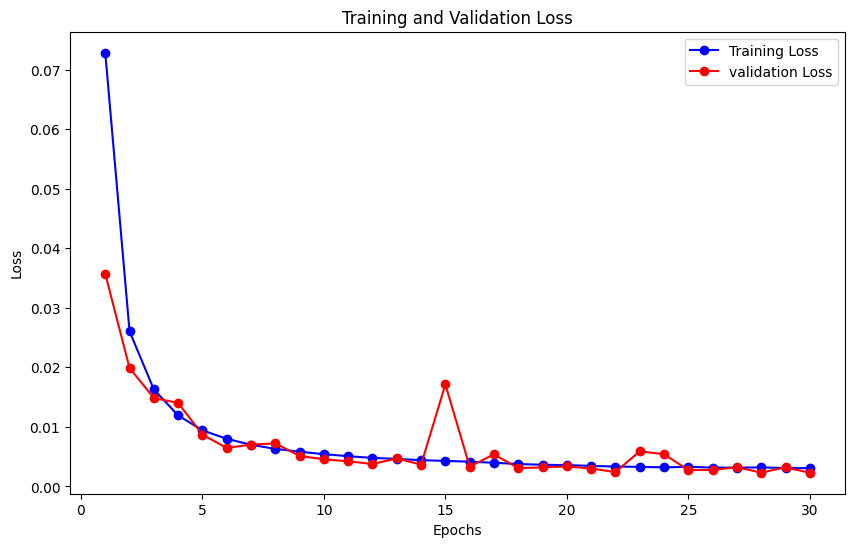

In [ ]:
#Get loss information
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,31)
#show history
plt.figure(figsize = (10,6))
plt.plot (epochs, train_loss, 'bo-', label='Training Loss')
plt.plot (epochs, val_loss, 'ro-', label='validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [ ]:
# random_index = np.random.randint(0, len(xval))
# random_image = xval[random_index]
# true_label = yval[random_index]
# random_image = random_image.reshape((1, 64))
# for i in range(64):
#       if true_label[i] == 1:
#           nhan = i
# plt.imshow(random_image, cmap='gray')
# plt.axis('off')
# plt.title(data_new[nhan])
# plt.show()

# print(true_label)
# # 4 pixel trở lên -
# #

1/1 [==============================] - 0s 175ms/step


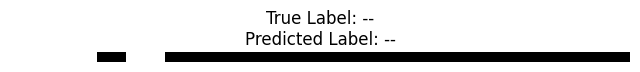

In [ ]:
random_index = np.random.randint(0, len(xtest))
random_image = xtest[random_index]
true_label = ytest[random_index]
random_image = random_image.reshape((1, 64))
for i in range(64):
      if true_label[i] == 1:
          nhan = i
predictions = model.predict(random_image)
predicted_label = np.argmax(predictions)
#Plot the image
plt.figure(figsize=(8,8))
# plt.imshow(random_image[0] * 255.0, cmap='gray')
plt.imshow(random_image, cmap='gray')
plt.title(f'True Label: {data_new[nhan]}\nPredicted Label: {data_new[predicted_label]}')
plt.axis('off')
plt.show()

1/1 [==============================] - 0s 17ms/step


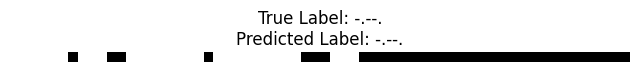

In [ ]:
random_index = np.random.randint(0, len(xtest))
random_image = xtest[random_index]
true_label = ytest[random_index]
random_image = random_image.reshape((1, 64))
for i in range(64):
      if true_label[i] == 1:
          nhan = i
predictions = model.predict(random_image)
predicted_label = np.argmax(predictions)
#Plot the image
plt.figure(figsize=(8,8))
# plt.imshow(random_image[0] * 255.0, cmap='gray')
plt.imshow(random_image, cmap='gray')
plt.title(f'True Label: {data_new[nhan]}\nPredicted Label: {data_new[predicted_label]}')
plt.axis('off')
plt.show()

##Train với data mới

Lấy data

In [ ]:
import pickle
file_path = '/content/gdrive/MyDrive/ML/spectrogram_dataset.pkl'

# Đọc dữ liệu từ tệp tin
with open(file_path, 'rb') as file:
    spectrogram_dataset = pickle.load(file)

In [ ]:
file_path = '/content/gdrive/MyDrive/ML/tap_y.pkl'

# Đọc dữ liệu từ tệp tin
with open(file_path, 'rb') as file:
    tap_y = pickle.load(file)

Các hàm xử lý

In [ ]:
#vẽ spectrogram
def plot_spectrogram(spectrogram, start=0, end=-1):
    plt.figure(figsize=(13, 4))
    librosa.display.specshow(spectrogram[:, start:end], sr=22050, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')
    plt.show()
threshold = -15
def silence_detection_num(spectrogram, show=False):
    mask_num = np.where(spectrogram < threshold, -80, -10)
    word_num = np.where(np.any(mask_num == -10, axis=0), '-', '.')
#     words = np.split(spectrogram, word_num, axis=1)

    if show:
        text = translate(word_num)

    return mask_num, text

def translate(symbols):
    symbols = ''.join(symbols)
    # Split the morse code into segments of consecutive dots or dashes
    segments = re.findall(r'\.+|-+', symbols)

    # Translate to Morse Code
    morse = ''
    for segment in segments:
        if '.' in segment:
            if len(segment) > 30:
                morse += '|'
            elif len(segment) > 5:
                morse += ' '
        elif '-' in segment:
            if len(segment) < 7:
                morse += '.'
            elif len(segment) >= 7:
                morse += '-'

    # Translate to Alphabetical Text
    ALPHA_TO_MORSE = { 'A':'.-', 'B':'-...',
                    'C':'-.-.', 'D':'-..', 'E':'.',
                    'F':'..-.', 'G':'--.', 'H':'....',
                    'I':'..', 'J':'.---', 'K':'-.-',
                    'L':'.-..', 'M':'--', 'N':'-.',
                    'O':'---', 'P':'.--.', 'Q':'--.-',
                    'R':'.-.', 'S':'...', 'T':'-',
                    'U':'..-', 'V':'...-', 'W':'.--',
                    'X':'-..-', 'Y':'-.--', 'Z':'--..',
                    '1':'.----', '2':'..---', '3':'...--',
                    '4':'....-', '5':'.....', '6':'-....',
                    '7':'--...', '8':'---..', '9':'----.',
                    '0':'-----', ', ':'--..--', '.':'.-.-.-',
                    '?':'..--..', '/':'-..-.', '-':'-....-',
                    '(':'-.--.', ')':'-.--.-', '=':'-...-'}

    MORSE_TO_ALPHA = {'.-': 'A', '-...': 'B',
                      '-.-.': 'C', '-..': 'D', '.': 'E',
                      '..-.': 'F', '--.': 'G', '....': 'H',
                      '..': 'I', '.---': 'J', '-.-': 'K',
                      '.-..': 'L', '--': 'M', '-.': 'N',
                      '---': 'O', '.--.': 'P', '--.-': 'Q',
                      '.-.': 'R', '...': 'S', '-': 'T',
                      '..-': 'U', '...-': 'V', '.--': 'W',
                      '-..-': 'X', '-.--': 'Y', '--..': 'Z',
                      '.----': '1', '..---': '2', '...--': '3',
                      '....-': '4', '.....': '5', '-....': '6',
                      '--...': '7', '---..': '8', '----.': '9',
                      '-----': '0', '--..--': ', ', '.-.-.-': '.',
                      '..--..': '?', '-..-.': '/', '-....-': '-',
                      '-.--.': '(', '-.--.-': ')', '-...-': '='}

    morse_string = morse.strip('|')
    words = morse_string.split('|')
    word_sequences = [word.split(' ') for word in words] # Output: [['-...-'], ['-.', '--', '.--']]

    text = ''
    for word in word_sequences:
        for char in word:
            try:
                text += MORSE_TO_ALPHA[char]
            except KeyError:
                text += '?'
        text += ' '

    return text

Chuyển đổi spectrogram_dataset và trích dữ liệu 50 mẫu



In [ ]:
tap_x = []
M = 50
for i in range(M):
    data, text = silence_detection_num(spectrogram_dataset[i], show=True)
    tap_x.append(data)  #tap_x gồm 50 mẫu (128, _)

tap_y_new = tap_y[:M]   #tap_y_new gồm 50 mẫu văn bản ứng với từng mẫu trong tap_x

##Lấy 1 mẫu trong tập data mới

In [ ]:
mau = 3

##Tiến hành xử lý mẫu

In [ ]:
# #Trích hàng chứa mã morse
# for j in range(len(X_train[1])):
#   for i in range(len(X_train[2])):
#       if X_train[30][j][i] != -80:
#           print("j = ",j)
#           # print("i = ",i)
#           # (_, 27 28 29, _)

In [ ]:
mau_thu = tap_x[mau][28][:]

In [ ]:
ma_tran = (mau_thu - np.min(mau_thu)) / (np.max(mau_thu) - np.min(mau_thu))

In [ ]:
ma_tran

array([0., 0., 0., ..., 0., 0., 0.])

In [ ]:
def xoa_phan_tu_bang_0(mang):
    mang_moi = [x for x in mang if np.sum(x) != 0]
    return mang_moi
def division_symbols (ma_tran):
    symbols = []
    sample = []
    index = 0
    count_0 = 0
    for i in range(index, len(ma_tran)):
        gia_tri = ma_tran[i]
        sample.append(gia_tri)
        # if (len(sample) == 8 and np.sum(sample) == 0):
        #     symbols.append([0])
        if gia_tri != 0:
            count_0 = 0
        if gia_tri == 0:
            count_0 += 1
        if count_0 >= 10:
            symbols.append(sample)
            index = i
            count_0 = 0

            sample = []
    # symbols
    return symbols

In [ ]:
symbols_temp = division_symbols(ma_tran)
# for i in range(len(symbols_temp)):
#   print(symbols_temp[i])
symbols_temp = xoa_phan_tu_bang_0(symbols_temp)

In [ ]:
def xoa_phan_tu_0_dau_tien(chuoi):
    da_tim_thay_phan_tu_khac_0 = False
    chuoi_sau_xoa = []
    for phan_tu in chuoi:
        if phan_tu != 0 or da_tim_thay_phan_tu_khac_0:
            chuoi_sau_xoa.append(phan_tu)
            da_tim_thay_phan_tu_khac_0 = True
    return chuoi_sau_xoa

In [ ]:
def resize_data(arr):
    image_n = np.reshape(arr, (1, len(arr)))
    image_resize = []
    chuoi_1 = []
    count = 0
    for i in range(len(image_n[0])):
        gia_tri = image_n[0][i]
        if np.all(gia_tri) == 1:
            chuoi_1.append(1)
        if np.all(gia_tri) == 0:
            if len(chuoi_1) >= 7:
                image_resize.extend([1,1,1,1,1,1])
            elif len(chuoi_1) < 7 and len(chuoi_1) > 2:
                image_resize.extend([1,1])
            chuoi_1 = []
            image_resize.append(0)
    for i in range(len(image_resize)):
      if image_resize[i] == 1:
            image_resize[i] = 255

    if len(image_resize) < 64:
          image_resize = xoa_phan_tu_0_dau_tien(image_resize)
          image_resize.extend([0]*(64-len(image_resize)))
    return image_resize

In [ ]:
symbols_temp_1 = []
for i in range(len(symbols_temp)):
   image_n = resize_data(symbols_temp[i])
   image_ = np.reshape(image_n, (1, len(image_n)))
   symbols_temp_1.append(image_)

In [ ]:
symbols_temp_1[3]

array([[255, 255,   0, 255, 255, 255, 255, 255, 255,   0,   0, 255, 255,
        255, 255, 255, 255,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]])

##Tiến hành dự đoán sau khi chia ký tự

In [ ]:
def predict(xval):
        random_image = xval.reshape((1, 64))
        predictions = model.predict(random_image)
        predicted_label = np.argmax(predictions)
        ki_tu_du_doan = label[predicted_label]
        return ki_tu_du_doan

In [ ]:
import json
predict_content = dict()
for i in range(len(symbols_temp_1)):
      predict_content[i] = predict(symbols_temp_1[i])
      plt.figure(figsize=(8,8))
      symbols_temp_1[i] = np.reshape(symbols_temp_1[i], (1, 64))
      plt.imshow(symbols_temp_1[i], cmap='gray')
      plt.axis('off')
      plt.show()
predict_content = ''.join(predict_content.values())
print("Văn bản dự đoán: ", predict_content)
print("Van ban dung: ", tap_y_new[mau])

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 54ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 73ms/step


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 52ms/step


1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 63ms/step


1/1 [==============================] - 0s 68ms/step


1/1 [==============================] - 0s 60ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 53ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 48ms/step


1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 68ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 46ms/step


1/1 [==============================] - 0s 55ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 55ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 180ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 46ms/step


1/1 [==============================] - 0s 54ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 52ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 54ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 55ms/step


1/1 [==============================] - 0s 55ms/step


1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 46ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 88ms/step


1/1 [==============================] - 0s 128ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 55ms/step


1/1 [==============================] - 0s 141ms/step


1/1 [==============================] - 0s 145ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 46ms/step


1/1 [==============================] - 0s 48ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 55ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 51ms/step


1/1 [==============================] - 0s 49ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 27ms/step


Văn bản dự đoán:  =NOY10YSM=VE_VIUFTOMOCVON~ET2018QUVSAGE88=WUCHCANADACHANDME_ICO.VRETEIUANOVRETYOTKUROSN~EINGRELDINLIMA,SETW,INOCVON~ET2019.GATECIN2005,VREFITUVGLON~ALAMAVEWTTADIOEMETGENCZCOMMWNICAVIONUGATECCONFETENCEYAUOTGANIU..EDINVAMSETE,FINLAND.VAMSETEIUYRETE,IN1998CHVREFITUVINVETGOXETNMENVALCONFETENCEONEMETGENCZVELECOMMWNICAVIONUICEV98ADOSVEDVREGTOWNDN~TEAKINGVAMSETE=ENDOF10YSMVE_V=QUVDEY1AY+
Van ban dung:  
  NOW 10 WPM    TEXT IS FROM FEBRUARY 2020 QST  PAGE 30  

STAR DASHBOARD SEE FIGURE 2.  TO CONFIGURE PI STAR TO WORK WITH YOUR
PI/PIHAT, SELECT THE CONFIGURATION BUTTON IN THE TOP RIGHT IF A SETTING IS
NOT MENTIONED, THE DEFAULT WILL WORK.  SELECT APPLY CHANGES BELOW EACH
PANEL TO UPDATE CHANGES TO THAT SPECIFIC PANEL.  ON THE CONTROL SOFTWARE
PANEL SEE FIGURE 3, SELECT MMDVM HOST AND SIMPLEX MODE.  ON THE MMDVM HOST
  END OF 10 WPM TEXT    QST DE W1AW  

